In [1]:
import tensorflow as tf
tf.logging.set_verbosity(tf.logging.ERROR)

# 通过Keras后端接口来编写代码
import keras.backend as K
from keras.models import Model
from keras.regularizers import l2
from keras.optimizers import RMSprop
from keras.layers.merge import concatenate
from keras.layers import Input, Reshape, Dense, Dropout
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.utils import plot_model


Using TensorFlow backend.


Model: "mm_ranking_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 3, 50)        0                                            
__________________________________________________________________________________________________
input_5 (InputLayer)            (None, 8, 50)        0                                            
__________________________________________________________________________________________________
input_6 (InputLayer)            (None, 5, 50)        0                                            
__________________________________________________________________________________________________
input_7 (InputLayer)            (None, 5, 50)        0                                            
___________________________________________________________________________________

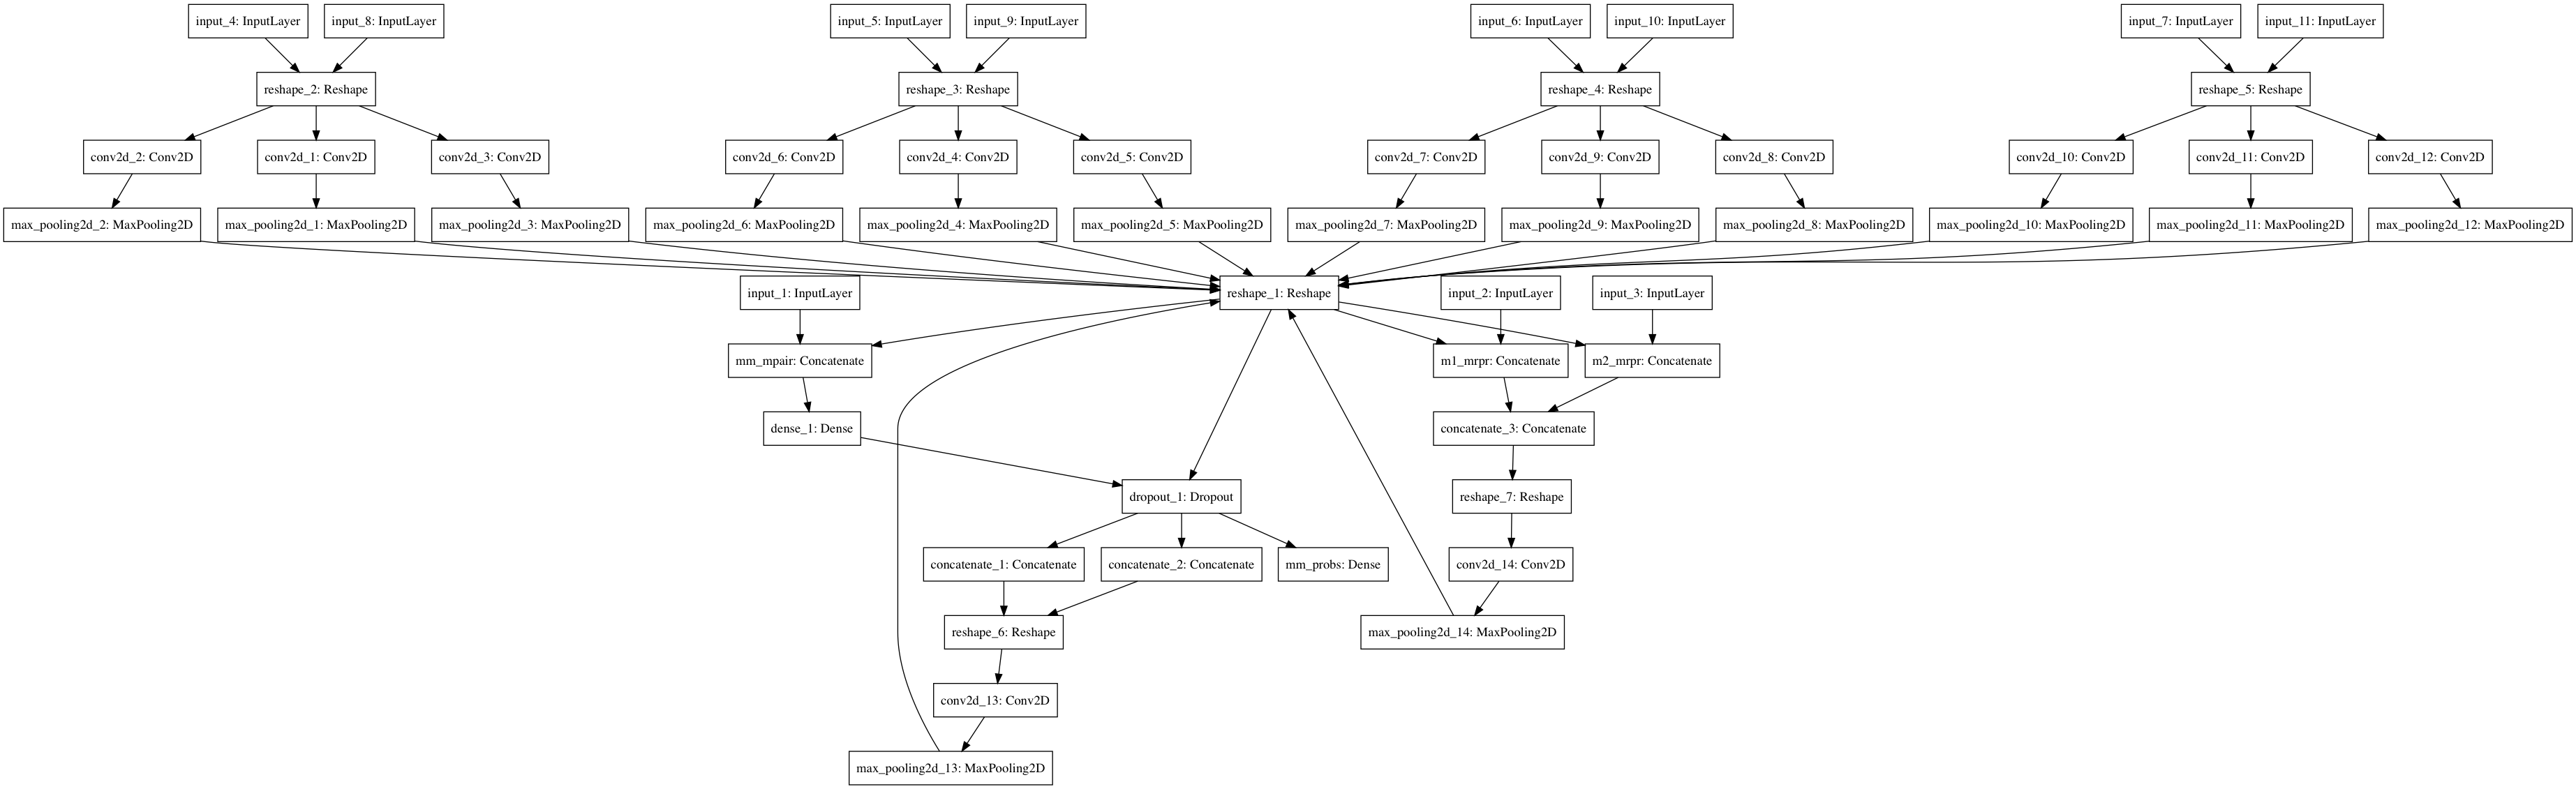

In [2]:
pftdim = 6
mftdim = 72
eftdims = [(3, 50), (8, 50), (5, 50), (5, 50)]
nb_fltrs = 280
nb_efts = 4

# 设置GPU选项
gpu=None
gpu_num = 1
gpu_opts = tf.GPUOptions(allow_growth=True, visible_device_list=','.join(map(str, gpu) if gpu else []))
# 实例化会话对象
sess = tf.InteractiveSession(config=tf.ConfigProto(allow_soft_placement=True, gpu_options=gpu_opts))
# with tf.compat.v1.Session(config=tf.ConfigProto(allow_soft_placement=True, gpu_options=gpu_opts)) as sess: 
# 将Keras作为tensorflow的精简接口
K.set_session(sess)
# 指定tensorflow运行的GPU或CPU设备
with tf.device('/device:GPU:%d' % gpu_num):
    # 定义共指消解输入层
    # 1. mention-pair的输入
    mm_pft = Input(shape=(pftdim,))
    # 2. mention1的输入， mention2的输入
    m1_mft, m2_mft = Input(shape=(mftdim,)), Input(shape=(mftdim,))
    # 3. 针对某个mention抽取出的所有特征的输入
    m1_efts = [Input(shape=(r, d)) for r, d in eftdims]
    # 4. 针对某个mention抽取出的所有特征的输入
    m2_efts = [Input(shape=(r, d)) for r, d in eftdims]

    # mention表达的命名空间
    with tf.name_scope('mrepr'):
        expand_dims, reshape_df, dropout = [], Reshape((nb_fltrs,)), Dropout(0.8)
        # 所有特征的1-gram卷积层序列，2-gram卷积层序列，3-gram卷积层序列，1-gram池化层序列，2-gram池化层序列，3-gram池化层序列
        eft_c1rs, eft_c2rs, eft_c3rs, eft_p1rs, eft_p2rs, eft_p3rs = [], [], [], [], [], []
        # 遍历每1个抽取出的特征的维度信息
        for r, d in eftdims:
            expand_dims.append(Reshape((r, d, -1)))
            # CONV1 卷积核窗口为1个单词，即1-gram滤波器，从卷积层输入形状(None, 2, 286, 1)表示channels为1，因此相当于Conv1D
            eft_c1rs.append(Conv2D(nb_fltrs, (1, d), activation='tanh'))
            # CONV1 卷积核窗口为2个单词，即2-gram滤波器
            eft_c2rs.append(Conv2D(nb_fltrs, (2, d), activation='tanh'))
            # CONV1 卷积核窗口为3个单词，即3-gram滤波器
            eft_c3rs.append(Conv2D(nb_fltrs, (3, d), activation='tanh'))
            # CONV1 卷积核窗口为1个单词的池化层
            eft_p1rs.append(MaxPooling2D(pool_size=(r - 0, 1)))
            # CONV1 卷积核窗口为2个单词的池化层
            eft_p2rs.append(MaxPooling2D(pool_size=(r - 1, 1)))
            # CONV1 卷积核窗口为3个单词的池化层
            eft_p3rs.append(MaxPooling2D(pool_size=(r - 2, 1)))

        # CONV2
        nb_rows, mrepr_conv = 3 * nb_efts, Conv2D(nb_fltrs, (1, nb_fltrs), activation='tanh')
        reshape_cefts, mrepr_pool = Reshape((nb_rows, nb_fltrs, -1)), MaxPooling2D(pool_size=(nb_rows, 1))

        def mrepr(m_efts, m_mft, name=None):
            eft_v1rs, eft_v2rs, eft_v3rs = [], [], []
            for expand_dim, eft, c1r, c2r, c3r, p1r, p2r, p3r \
                    in zip(expand_dims, m_efts, eft_c1rs, eft_c2rs, eft_c3rs, eft_p1rs, eft_p2rs, eft_p3rs):
                eft_e = expand_dim(eft)
                eft_v1rs.append(dropout(reshape_df(p1r(c1r(eft_e)))))
                eft_v2rs.append(dropout(reshape_df(p2r(c2r(eft_e)))))
                eft_v3rs.append(dropout(reshape_df(p3r(c3r(eft_e)))))

            eft_mat = reshape_cefts(concatenate(eft_v1rs + eft_v2rs + eft_v3rs))
            eft_vec = reshape_df(mrepr_pool(mrepr_conv(eft_mat)))

            return concatenate([eft_vec, m_mft], name=name)

        m1_mrepr = mrepr(m1_efts, m1_mft, name='m1_mrpr')
        m2_mrepr = mrepr(m2_efts, m2_mft, name='m2_mrpr')

    # mention-pair表达的命名空间
    with tf.name_scope('mpair'):
        mpair_conv = Conv2D(nb_fltrs, (1, nb_fltrs + mftdim), activation='tanh')
        reshape_reprs, mpair_pool = Reshape((2, nb_fltrs + mftdim, -1)), MaxPooling2D(pool_size=(2, 1))

        def mpair(mrepr1, mrepr2, pwft, name=None):
            mat = reshape_reprs(concatenate([mrepr1, mrepr2]))
            pft_vec = reshape_df(mpair_pool(mpair_conv(mat)))
            return concatenate([pft_vec, pwft], name=name)

        mm_mpair = mpair(m1_mrepr, m2_mrepr, mm_pft, name='mm_mpair')

    # 预测mention-pair中两个mention关系的命名空间
    with tf.name_scope('preds'):
        mm_hidden = dropout(Dense(nb_fltrs, activation='relu')(mm_mpair))
        mm_probs = Dense(3, activation='softmax', name='mm_probs', kernel_regularizer=l2(0.005))(mm_hidden)

# 构造mention嵌入表达的模型
mrepr_inputs = m2_efts + [m2_mft]
mrepr_model = Model(inputs=mrepr_inputs, outputs=[m2_mrepr], name='mm_mrepr_model')

# 构造mention-parir嵌入表达的模型
mpair_inputs = m1_efts + m2_efts + [m1_mft, m2_mft, mm_pft]
mpair_model = Model(inputs=mpair_inputs, outputs=[mm_mpair], name='mm_mpair_model')

# 构建mention-pair排序得分模型
ranking_inputs = m1_efts + m2_efts + [m1_mft, m2_mft, mm_pft]
ranking_model = Model(inputs=ranking_inputs, outputs=[mm_probs], name='mm_ranking_model')
ranking_model.compile(optimizer=RMSprop(), 
                      loss=['sparse_categorical_crossentropy'], 
                      metrics=['sparse_categorical_accuracy'])
ranking_model.summary()
plot_model(ranking_model, to_file='./model.png')